<a href="https://colab.research.google.com/github/PedroOlavo/Apps-Streamlit/blob/main/Test_YipitData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the libraries
import pandas as pd
import numpy as np

In [2]:
#reading the data
sheet_id = '1a-BnMRzx6wQlNU2qGl9y8Q5lcCgueWppxq13iBbU1EM'
sheet_name = 'Data'
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
columns = ['merchant', 'user_id', 'year', 'panel_start_date', 'panel_status', 'user_spend']
data = pd.read_csv(url, usecols=columns)
data.head()

,merchant,user_id,year,panel_start_date,panel_status,user_spend
0,wayfair,5cd327b15e0d4832bf75dd129de12dfe,2022-01-01,2021-02-22,inactive,1765.94
1,wayfair,1cb4e35332e04ceb9a3c175174097d4b,2022-01-01,2017-05-03,active,199.97
2,wayfair,ea57b7b1585644b3ab35b10a9201ba17,2022-01-01,2022-12-05,active,259.99
3,wayfair,e60141b69fa449008a5c688f1eb51379,2022-01-01,2016-10-23,active,969.99
4,wayfair,615aa1b89a0c4cd69eb2866074e334e6,2022-01-01,2017-01-10,active,110.13


In [3]:
#Now we have our dataframe
#Lets check the datatypes from our dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150123 entries, 0 to 150122
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   merchant          150123 non-null  object 
 1   user_id           150123 non-null  object 
 2   year              150123 non-null  object 
 3   panel_start_date  150123 non-null  object 
 4   panel_status      150123 non-null  object 
 5   user_spend        150123 non-null  float64
dtypes: float64(1), object(5)
memory usage: 6.9+ MB


In [4]:
#In the dictonary we have the information that the column "year" has two values, lets see if it`s correct
print(data['year'].unique())

['2022-01-01' '2021-01-01']


In [5]:
#Now we saw that, I`ll replace the values to contain only the year
data['year'] = data['year'].replace('2022-01-01', '2022')
data['year'] = data['year'].replace('2021-01-01', '2021')
print(data['year'].unique())

['2022' '2021']


In [6]:
#We had have deal with the year column, now let`s slice the data only with the sales from wayfair
#First we need to check if all the entry in the column merchant are written the same
data['merchant'].unique()

array(['wayfair', 'west_elm', 'build_com'], dtype=object)

In [7]:
#So we dont have problems with the entry there
#We can keep going to slice the data
data_wayfair = data.loc[data['merchant'] == 'wayfair'].copy()
data_wayfair.head()

,merchant,user_id,year,panel_start_date,panel_status,user_spend
0,wayfair,5cd327b15e0d4832bf75dd129de12dfe,2022,2021-02-22,inactive,1765.94
1,wayfair,1cb4e35332e04ceb9a3c175174097d4b,2022,2017-05-03,active,199.97
2,wayfair,ea57b7b1585644b3ab35b10a9201ba17,2022,2022-12-05,active,259.99
3,wayfair,e60141b69fa449008a5c688f1eb51379,2022,2016-10-23,active,969.99
4,wayfair,615aa1b89a0c4cd69eb2866074e334e6,2022,2017-01-10,active,110.13


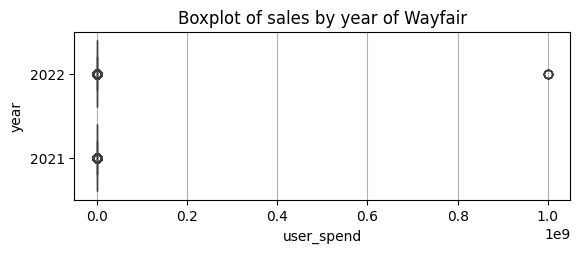

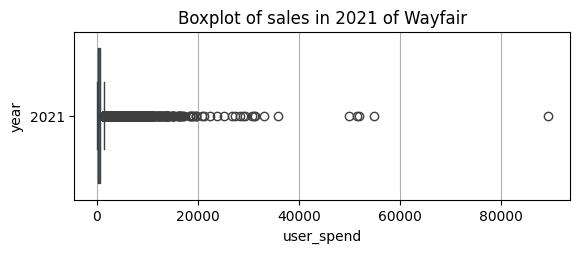

In [8]:
#Here we have a problem, its seem that the sales has increased 14300% from 2021 to 2022.
#Let`s dive in the values of sales of 2022 to search for outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.subplot(2,1,1)
plt.grid()
sns.boxplot(data_wayfair, x='user_spend', y='year')
plt.title('Boxplot of sales by year of Wayfair')
plt.show()

plt.subplot(2,1,2)
plt.grid()
sns.boxplot(data_wayfair.loc[data_wayfair['year']=='2021'], x='user_spend', y='year')
plt.title('Boxplot of sales in 2021 of Wayfair')
plt.show()

In [9]:
#First we need to discover how many times that entry of 1kk occurs
#We can also see some outliers in the second boxplot, which represent the sales in 2021
#I will not treat them because they can be very important, in other analysis it can be
#usefull understand why there is such shopping orders to try to achive more orders like that
occ_1billion = (data_wayfair['user_spend'] == 1000000000).sum()
occ_1billion

6

In [10]:
#Since that happens six times, we need to rip off those six entrys
list_indexs = data_wayfair[data_wayfair['user_spend'] == 1000000000].index
data_wayfair = data_wayfair.drop(list_indexs)
data_wayfair['user_spend'].max()

89376.58

In [11]:
#Now we can calculate the total sales of Wayfair in 2021 and 2022
total_sales_year = data_wayfair.groupby('year')['user_spend'].sum()
total_sales_2021 = int(total_sales_year[0])
total_sales_2022 = int(total_sales_year[1])
total_sales_2021, total_sales_2022

(42058620, 34495972)

In [12]:
#Moving on we will calculate the retention
#Retetion can be defined as the percentage of users that shopped in 2021 and returned to shopp in 2022
#Identify customers that shopped 2021
customers_2021 = set(data_wayfair[data_wayfair['year'] == '2021']['user_id'].unique())

#Identify customers that shopped 2022
customers_2022 = set(data_wayfair[data_wayfair['year'] == '2022']['user_id'].unique())

#Calculate the intersection of the customers
retained_customers = customers_2021.intersection(customers_2022)

#Calculate the retention percentage
retained_percentage = len(retained_customers) / len(customers_2021) * 100

#Show the retention percentage
print(f"Customer retention percentage: {retained_percentage:.2f}%")

Customer retention percentage: 25.08%


In [13]:
#In the next part we will calculate how much of receipt those retained customers had brought in 2022
#We`ll start by filter the Wayfair dataset only by the retained customers
retained_customers_df = data_wayfair[data_wayfair['user_id'].isin(retained_customers)]

#Include only the shopping by retained customers in 2022
shopping_retained_customers_2022 = retained_customers_df[(retained_customers_df['year'] == '2022')]

#Evaluate the revenue by the shopping of the retained customers
revenue_retained_customers_2022 = shopping_retained_customers_2022['user_spend'].sum()

#Calculate the percentage of the sales of 2022 that comes from retained customers
perc_revenue_retained_customers = round(revenue_retained_customers_2022 / total_sales_2022, 3) * 100
print(f"Revenue by retained customers: {perc_revenue_retained_customers:.1f}%")

Revenue by retained customers: 41.8%


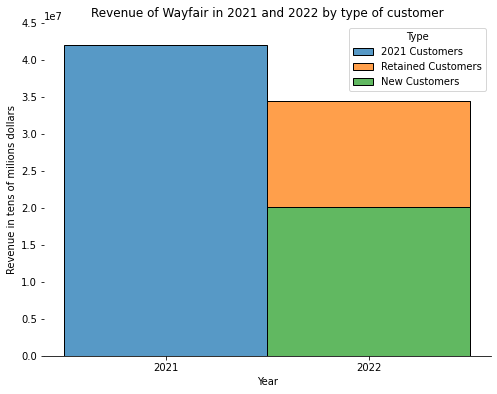

In [74]:
#Now lets design a barplot to have a look in a visual to the sales of 2021 and 2022
#FOr this I will part the sales of 2022 in retained customers and new customers.

revenue_new_customers_2022 = total_sales_2022 - revenue_retained_customers_2022
new_customers_2022 = customers_2022 - retained_customers

df_2021 = data_wayfair[data_wayfair['year']=='2021'].copy()
revenue_2021 = df_2021['user_spend'].sum()
rev_2022 = pd.DataFrame({
    'Year':[2021,2022, 2022],
    'Revenue':[revenue_2021 ,revenue_retained_customers_2022, revenue_new_customers_2022],
    'Type':['2021 Customers','Retained Customers', 'New Customers']
})


plt.figure(figsize=(8,6), dpi=72)
sns.histplot(rev_2022, x='Year', weights="Revenue", hue='Type', multiple='stack', discrete=True)
plt.xticks([2021, 2022])
sns.despine(left=True)
plt.title("Revenue of Wayfair in 2021 and 2022 by type of customer")
plt.ylim(0,45000000)
plt.ylabel("Revenue in tens of milions dollars")
plt.savefig('revenue.jpg')
plt.show()

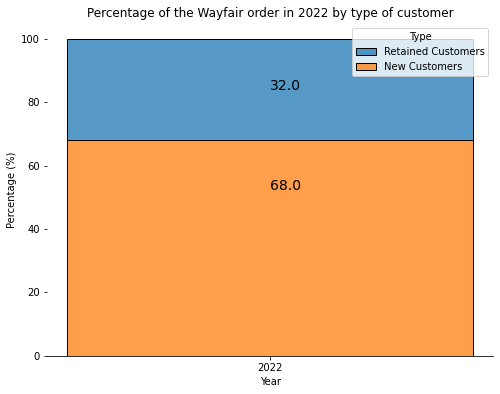

In [76]:
cus_2022 = pd.DataFrame({
    'Year':[2022, 2022],
    'Percentage':[round(len(retained_customers)/len(customers_2022),2)*100, round(len(new_customers_2022)/len(customers_2022),2)*100],
    'Type':['Retained Customers', 'New Customers']
})

new_customers_percentage = (round((len(new_customers_2022)/len(customers_2022)),2))*100
retained_perc_relation_to2022 = round((len(retained_customers)/len(customers_2022)),2)*100
plt.figure(figsize=(8,6), dpi=72)
ax = sns.histplot(cus_2022, x='Year', weights="Percentage", hue='Type', multiple='stack', discrete=True)
plt.xticks([2022])
sns.despine(left=True)
plt.title("Percentage of the Wayfair order in 2022 by type of customer")
plt.text(0.5, 0.5, new_customers_percentage, transform=ax.transAxes, fontsize=14)
plt.text(0.5, 0.8, retained_perc_relation_to2022, transform=ax.transAxes, fontsize=14)
plt.ylabel("Percentage (%)")
plt.savefig('percentage.jpg')
plt.show()

In [ ]:
#In the image above we can see that from all the customers that shopped in Wayfair in 2022,
#32% of them were retained customers and 41.8% of the revenue in 2022 were due to these customers.
